# Split data from main dataset json

Train: 20
Library functions included in the dataset: 36
✅ External functions used saved to /root/Thesis_project/data/MBPP_Midio_50/metadata/used_external_functions.json as a valid JSON array.
Unique External function in train: 36
Val: 10
Library functions included in the dataset: 19
✅ External functions used saved to /root/Thesis_project/data/MBPP_Midio_50/metadata/used_external_functions.json as a valid JSON array.
Unique External function in val: 19
Test: 20
Library functions included in the dataset: 37
✅ External functions used saved to /root/Thesis_project/data/MBPP_Midio_50/metadata/used_external_functions.json as a valid JSON array.
Unique External functions in test: 37


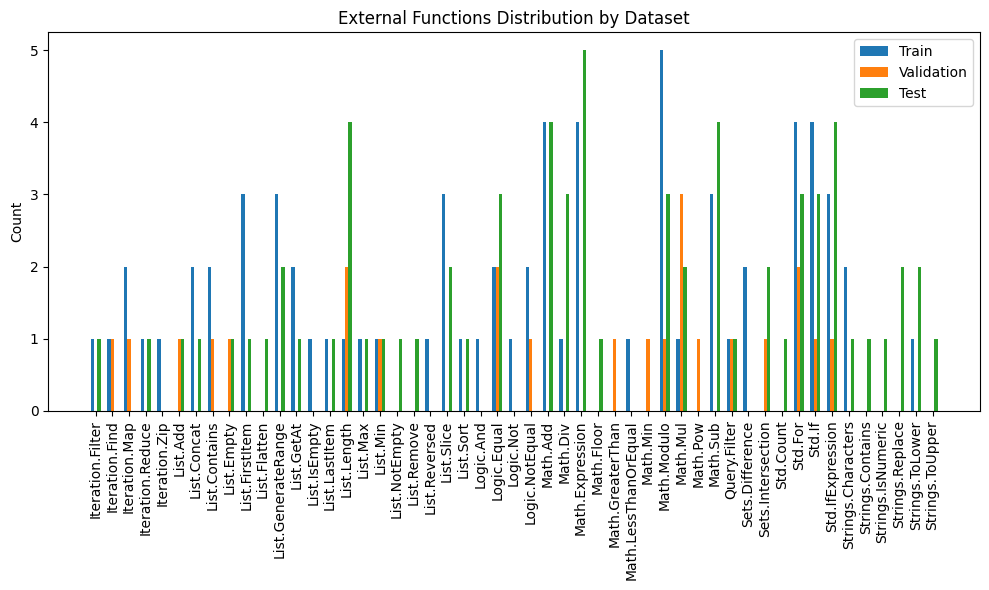

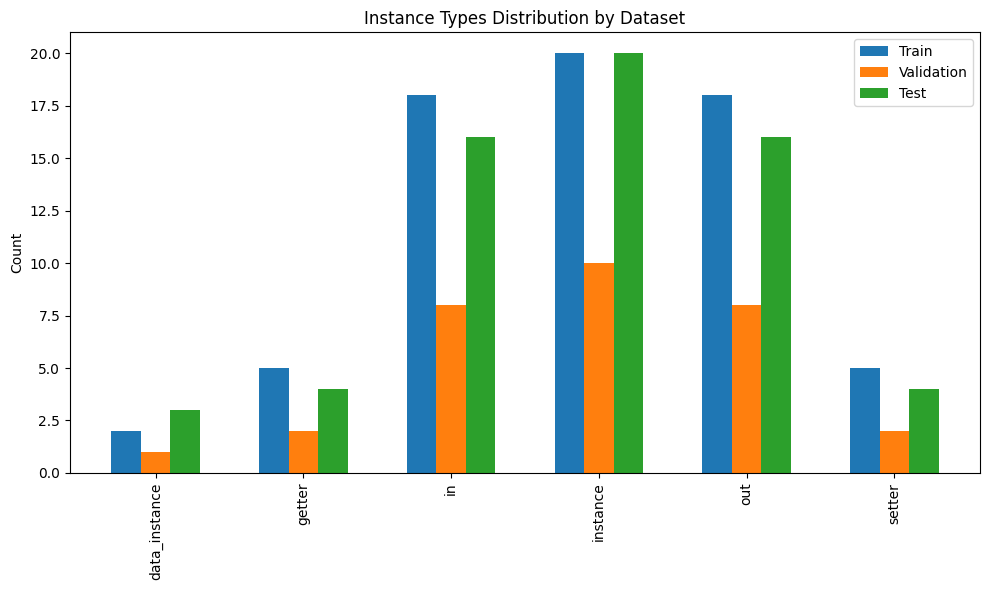

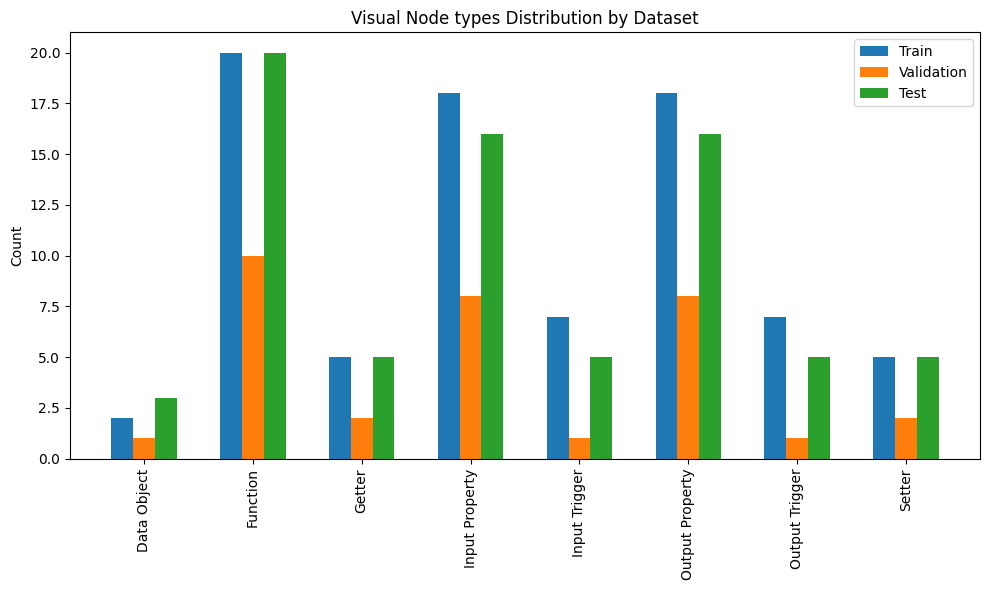

In [14]:

import sys

import numpy as np
from sklearn.model_selection import train_test_split
sys.path.append('../../')  # Add the path to the my_packages module
from my_packages.utils.file_utils import read_dataset_to_json
from my_packages.data_processing.split_dataset import multi_stratified_split
from my_packages.data_processing.attributes_processing import used_functions_from_dataset, used_functions_to_string
from my_packages.analysis.analyze_datasets import analyze_functions_distribution, analyze_instance_distribution, analyze_visual_node_types_distribution

main_dataset_folder = '../../data/MBPP_Midio_50/MBPP-Midio-50.json'
dataset = read_dataset_to_json(main_dataset_folder)
## TEst:
data = np.array(dataset, dtype=object)
train, test= train_test_split(
    data, test_size=0.6, random_state=3, shuffle=True
)
val, test = train_test_split(
    test, test_size=0.65, random_state=9, shuffle=True, 
)
# 1) Load the data
# train, val, test = multi_stratified_split(dataset, True, 0.4, seed=58)
print(f"Train: {len(train)}")
print(f"Unique External function in train: {len(used_functions_from_dataset(train))}")
print(f"Val: {len(val)}")
print(f"Unique External function in val: {len(used_functions_from_dataset(val))}")
print(f"Test: {len(test)}")
print(f"Unique External functions in test: {len(used_functions_from_dataset(test))}")
# Analyze distribution across train / val / tes
analyze_functions_distribution(train, val, test)
analyze_instance_distribution(train, val, test)
analyze_visual_node_types_distribution(train, val, test) 

# used_functions_json = used_functions_from_dataset(dataset)
# available_nodes = used_functions_to_string(used_functions_json)

# Upload to Langsmith

## Node prediction

In [2]:

# import datetime
# from langsmith import Client, schemas
# from my_packages.prompting.few_shot import transform_node_data
# from dotenv import load_dotenv

# load_dotenv("../../.env")

# train_data = transform_node_data(train)
# val_data = transform_node_data(val)
# test_data = transform_node_data(test)

# data_splits = {
#     "train": train_data, 
#     "validation": val_data,
#     "test": test_data
# }

# langsmith = Client()
# langsmith_dataset_name = "Node prediction"

# if langsmith.has_dataset(dataset_name=langsmith_dataset_name):
#     langsmith_dataset=langsmith.read_dataset(dataset_name=langsmith_dataset_name)
#     print("Existing dataset found.")
#     print("Deleting existing dataset.")
#     examples = langsmith.list_examples(
#         dataset_name=langsmith_dataset_name,
#         splits=["train", "validation", "test"],
#         metadata={"task_id": "1"},
#         limit=5
#     )
#     for e in examples:
#         print(e.inputs)

#     input_str = input("Do you want to delete the existing dataset? (y/n): ")
#     if input_str.lower() == "y":
#         langsmith.delete_dataset(dataset_name=langsmith_dataset_name)
#         print("Existing dataset deleted.")
#     else:
#         print("Existing dataset not deleted.")
    
# else:
    
#     langsmith_dataset = langsmith.create_dataset(
#         dataset_name=langsmith_dataset_name, 
#         description="Tasks and responses for node prediction",
#         data_type=schemas.DataType.kv,
#     )
#     langsmith.update_dataset_tag(
#         dataset_name=langsmith_dataset_name,
#         as_of=datetime.datetime.now(), 
#         tag="dev"
#     )

#     print("New dataset created.")

#     # Upload the data to langsmith
#     for split_name, dataset in data_splits.items():
#         langsmith.create_examples(
#             inputs=[{"task": sample["task"]} for sample in dataset],
#             outputs=[{"response": sample["response"]} for sample in dataset],
#             metadata=[{
#                 "task_id": sample["task_id"], 
#                 "MBPP_task_id": sample["MBPP_task_id"],
#                 "external_functions": sample["external_functions"],
#                 }
#                 for sample in dataset
#             ],
#             splits=[split_name for _ in dataset],
#             dataset_name=langsmith_dataset_name,
#         )

## Code prediction

In [15]:

import datetime
from langsmith import Client, schemas
from my_packages.prompting.few_shot import transform_code_data
from dotenv import load_dotenv

load_dotenv("../../.env")
print(train[0])
train_data = transform_code_data(train)
val_data = transform_code_data(val)
test_data = transform_code_data(test)

data_splits = {
    "train": train_data, 
    "validation": val_data,
    "test": test_data
}

langsmith = Client()
langsmith_dataset_name = "Code prediction V2"

if langsmith.has_dataset(dataset_name=langsmith_dataset_name):
    langsmith_dataset=langsmith.read_dataset(dataset_name=langsmith_dataset_name)
    print("Existing dataset found.")
    print("Deleting existing dataset.")

    input_str = input("Do you want to delete the existing dataset? (y/n): ")
    if input_str.lower() == "y":
        langsmith.delete_dataset(dataset_name=langsmith_dataset_name)
        print("Existing dataset deleted.")
    else:
        print("Existing dataset not deleted.")
    
else:
    
    langsmith_dataset = langsmith.create_dataset(
        dataset_name=langsmith_dataset_name, 
        description="Tasks and responses for code prediction",
        data_type=schemas.DataType.kv,
    )
    langsmith.update_dataset_tag(
        dataset_name=langsmith_dataset_name,
        as_of=datetime.datetime.now(), 
        tag="dev"
    )

    print("New dataset created.")

    # Upload the data to langsmith
    for split_name, dataset in data_splits.items():
        langsmith.create_examples(
            inputs=[{"task": sample["task"], "function_signature": sample["function_signature"]} for sample in dataset],
            outputs=[{"response": sample["response"]} for sample in dataset],
            metadata=[{
                "task_id": sample["task_id"], 
                "MBPP_task_id": sample["MBPP_task_id"],
                "external_functions": sample["external_functions"],
                "testing": {
                    "function_signature": sample["function_signature"],
                    "tests": sample["tests"]
                }
            }
            for sample in dataset
            ],
            splits=[split_name for _ in dataset],
            dataset_name=langsmith_dataset_name,
        )

{'prompts': ['Create a function to find the first repeated character in a given string.', "The created user-defined function 'first_repeated_char' should then be tested inside a seperate module called tests, within the main module. Since the user-defined function uses input and ouput triggers, the flow of execution is sent between the created function and assert nodes, using their input and output triggers."], 'task_id': 23, 'specification': {'function_signature': 'func(doc: "finds the first repeated character in a given string.") first_repeated_char {\n\tin(x: -20, y: -110, name: "execute") trigger() execute_97d5d5\n\tin(x: -216, y: 83, name: "string") property(String) string_71a657\n\tout(x: 1545, y: 186, name: "continue") trigger() continue_1914e0\n\tout(x: 904, y: 359, name: "char") property(Any) char_f2523c\n}', 'preconditions': '- There are no preconditions, the method will always work. Strings and sequences are always not null.', 'postconditions': '- If returns char, then return